In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from IPython import display

TensorFlow 2.x selected.


In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits
    
    def load(self, fname=None):
      if fname:
        self.inference_net.load_weights(f'{fname}-inference-net-weights.h5')
        self.generative_net.load_weights(f'{fname}-generative-net-weights.h5')
      else:
        self.inference_net.load_weights('inference-net-weights.h5')
        self.generative_net.load_weights('generative-net-weights.h5')


In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [0]:
epochs = 500
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [9]:
# Inference Net Summary
model.inference_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               461000    
Total params: 479,816
Trainable params: 479,816
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Generative Net
model.generative_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              158368    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 195,617
Trainable params: 195,617
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_and_save_images(model, epoch, test_input, folder='images', save_img=False):
  if not os.path.exists(folder):
    os.mkdir(folder)
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  if save_img:
    plt.savefig(f'./{folder}/{folder}_{epoch:04d}.png')
  plt.show()

ETA: 0:00	Epoch: 500/500	Train set ELBO: -73.3157	Test set ELBO: -73.3157


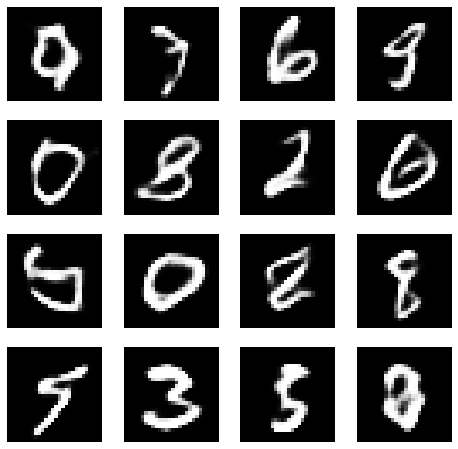

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation, save_img=True)

train_losses = []
test_losses = []
time_elapsed = 0
start_training = time.perf_counter()

for epoch in range(1, epochs + 1):
  train_loss = tf.keras.metrics.Mean()
  test_loss = tf.keras.metrics.Mean()
  
  start_time = time.perf_counter()
  for train_x in train_dataset:
     train_loss(compute_apply_gradients(model, train_x, optimizer))

  for test_x in test_dataset:
    test_loss(compute_loss(model, test_x))
  end_time = time.perf_counter()

  train_losses.append(-train_loss.result())
  test_losses.append(-test_loss.result())
  time_elapsed = max(time_elapsed, end_time - start_time)

  display.clear_output(wait=True)
  print(f'ETA: {int((time_elapsed * (epochs - epoch)) // 60)}:{int(time_elapsed * (epochs - epoch)) % 60:02d}\tEpoch: {epoch}/{epochs}\tTrain set ELBO: {train_losses[-1]:.4f}\tTest set ELBO: {train_losses[-1]:.4f}')
  generate_and_save_images(model, epoch, random_vector_for_generation, save_img=(epoch % 25 == 0))

training_time = time.perf_counter() - start_training

In [13]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 0:47:49


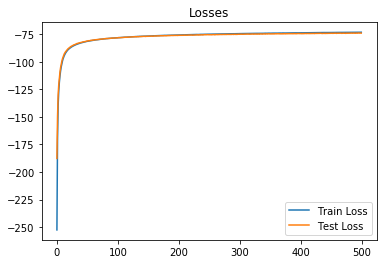

In [14]:
plt.plot(list(range(epochs)), train_losses, label='Train Loss')
plt.plot(list(range(epochs)), test_losses, label='Test Loss')
plt.title('Losses')
plt.legend()

plt.savefig('cvae-losses.png')
plt.show()

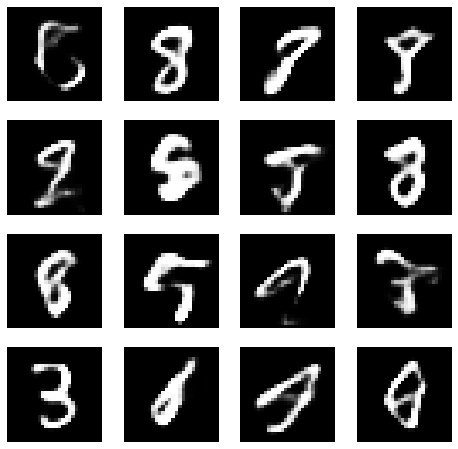

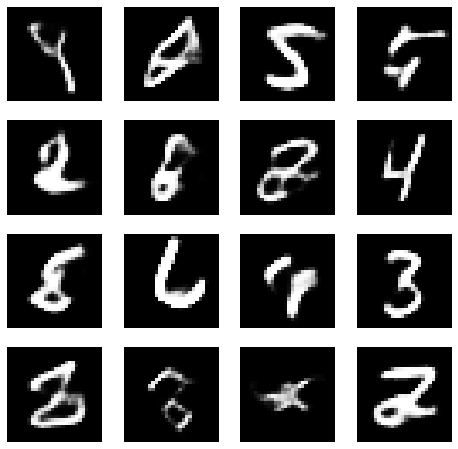

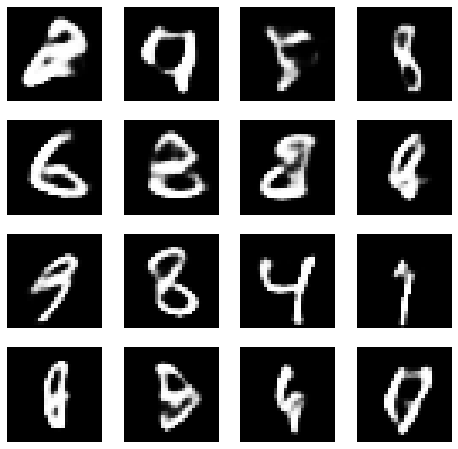

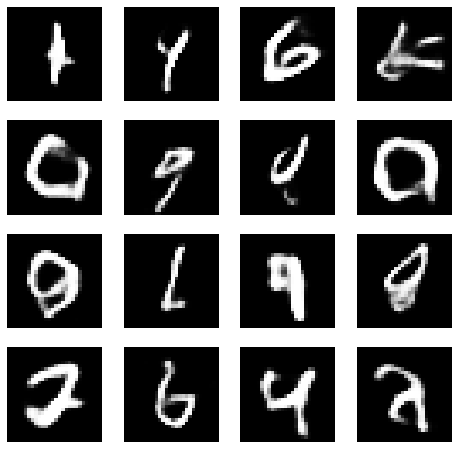

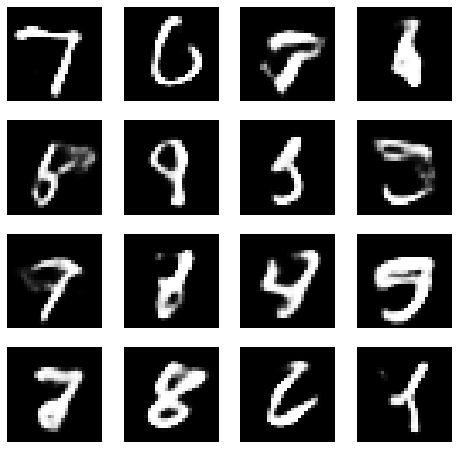

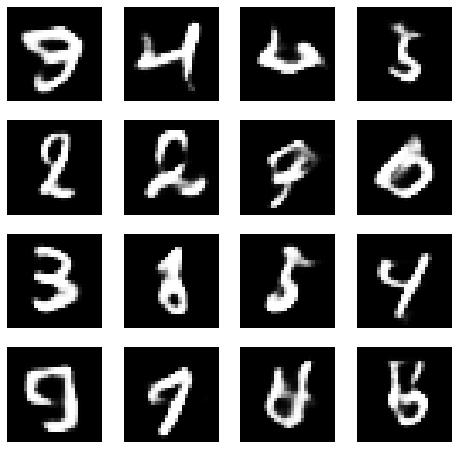

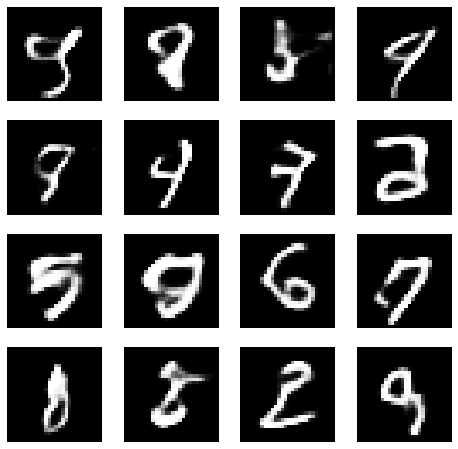

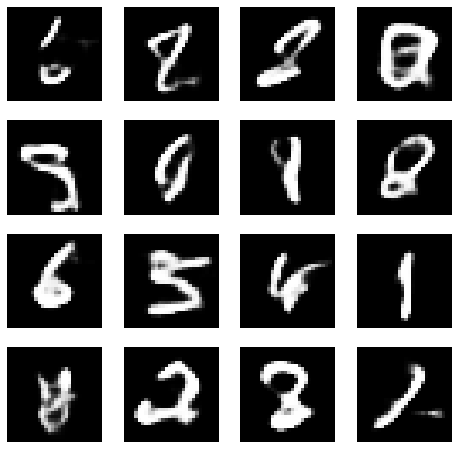

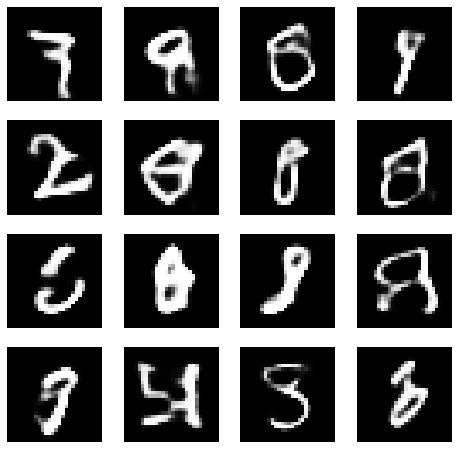

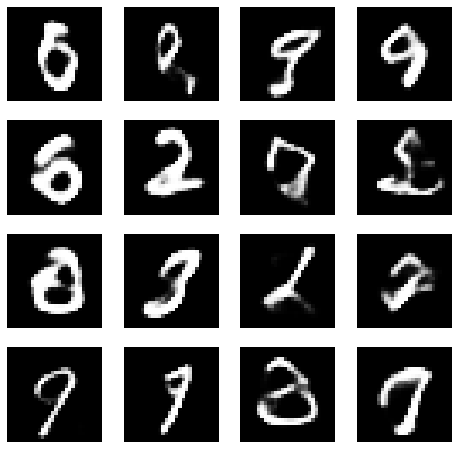

In [15]:
for j in range(10):
  seed = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
  generate_and_save_images(model, j, seed, 'samples', True)

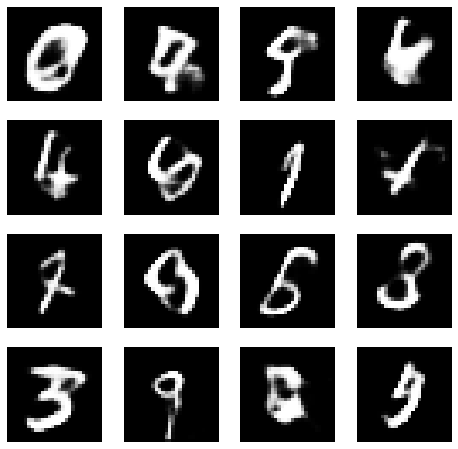

Predictions for above generated imagrs:
 [[0 4 9 6]
 [4 6 1 4]
 [7 9 5 3]
 [3 9 8 9]]


In [16]:
seed = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
samples = model.sample(seed )

benchmark_model = tf.keras.models.load_model('mnist-benchmark.h5')
predictions = benchmark_model.predict_classes(samples)

fig = plt.figure(figsize=(8, 8))

for i in range(samples.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.show()
print('Predictions for above generated imagrs:\n', predictions.reshape((4, 4)))